Le but de ce TP est de réaliser l'extraction de features d'images afin d'en réaliser une segmentation (apprentissage NON supervisé) puis de comparer les résultats de cette segmentation avec les classes d'origine (nous réaliserons une réelle classification dans un TP ultérieur). L'idée est plutôt d'informer la faisabilité d'un moteur de classification d'images tout en étudiant au passage la pertinence du choix du référentiel de classes.

Mettre à jour au fur et à mesure la cellule suivante des imports.

In [133]:
from glob import glob
import os

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Préparation du dataset

Récupérer le chemin du dossier contenant les images du fichier .env.

In [17]:
load_dotenv()
IMG_FOLDER = os.getenv("IMG_FOLDER")

Initialiser une constante contenant la liste référentielle des labels possibles.

In [18]:
LABELS_LIST = ["cloudy", "rain", "shine", "sunrise"]

En observation la convention de nommage des fichiers images, écrire une fonction (efficace) permettant de déterminer le label d'une photo à partir du nom du fichier.

In [19]:
def get_image_label(
    filename: str,
    possible_labels: list[str] | None = None,
    label_not_found_value: str = "unknown",
) -> str:
    possible_labels = (
        LABELS_LIST
        if possible_labels is None
        else possible_labels
    )
    for possible_label in possible_labels:
        if possible_label in filename:
            return possible_label
    return label_not_found_value

Ecrire une fonction créant un dataframe pandas contenant le chemin vers l'image et le label. Construire le dataframe associé à notre jeu de données.

In [23]:
def create_df_from_img(path: str) -> pd.DataFrame:
    df_out = pd.DataFrame(
        data={
            "image_path": glob(f"{path}*/*.jp*g"),
        }
    )
    df_out["label_name"] = df_out["image_path"].apply(
        get_image_label
    )
    return df_out


img_df = create_df_from_img(IMG_FOLDER)

In [24]:
img_df.head()

,image_path,label_name
0,../../data\weather-dataset\cloudy1.jpg,cloudy
1,../../data\weather-dataset\cloudy10.jpg,cloudy
2,../../data\weather-dataset\cloudy100.jpg,cloudy
3,../../data\weather-dataset\cloudy101.jpg,cloudy
4,../../data\weather-dataset\cloudy102.jpg,cloudy


Encoder le label à l'aide du LabelEncoder de scikit-learn.

In [29]:
label_encoder = LabelEncoder()
label_encoder.fit(LABELS_LIST)
img_df["label"] = label_encoder.transform(img_df["label_name"])
# img_df["label"] = label_encoder.fit_transform(img_df["label_name"])

In [30]:
img_df.tail()

,image_path,label_name,label
1120,../../data\weather-dataset\sunrise95.jpg,sunrise,3
1121,../../data\weather-dataset\sunrise96.jpg,sunrise,3
1122,../../data\weather-dataset\sunrise97.jpg,sunrise,3
1123,../../data\weather-dataset\sunrise98.jpg,sunrise,3
1124,../../data\weather-dataset\sunrise99.jpg,sunrise,3


Vérifier le nombre d'images dans chaque classe.

In [ ]:
img_df.groupby("label_name").count()

,image_path,label
label_name,,
cloudy,300,300
rain,215,215
shine,253,253
sunrise,357,357


In [32]:
img_df["label_name"].value_counts()

label_name
sunrise    357
cloudy     300
shine      253
rain       215
Name: count, dtype: int64

La cellule suivante (utilisant matplotlib) permet de visualiser 3 images côte à côte représentatives de chaque label. L'exécuter pour vérifier la cohérence de la sortie.

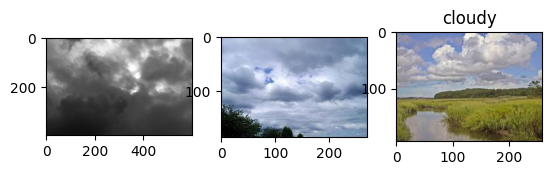

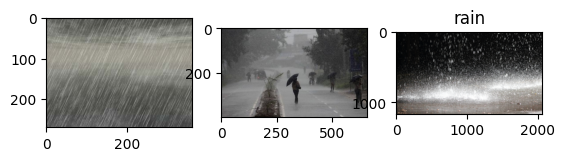

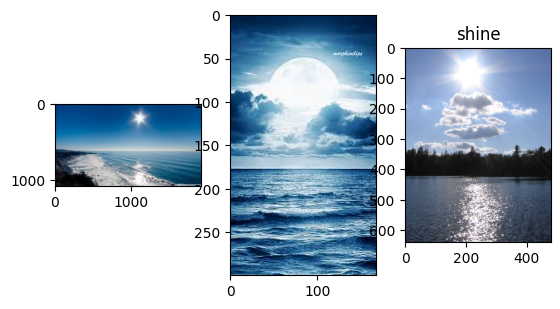

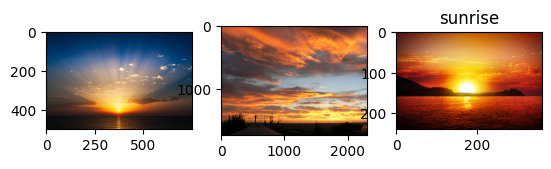

In [34]:
for label_name in LABELS_LIST:
    mask = img_df["label_name"]==label_name
    image_path_list = img_df[mask].reset_index().loc[0:2, "image_path"]
    for i in range(3):
        image = plt.imread(image_path_list[i])  
        plt.subplot(131 + i)
        plt.imshow(image)
    plt.title(label_name)
    plt.show() 

## Feature extraction

### Création du modèle pré-entraîné

Charger le modèle VGG16 de tensorflow.keras.applications.vgg16. Pour plus de renseignements sur l'architecture de VGG16, il est possible de consulter par exemple la ressource suivante : https://datacorner.fr/vgg-transfer-learning/.

In [36]:
base_model = VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Afficher les 5 dernières couches du modèle à l'aide de .layers.

In [39]:
base_model.layers[-5:]

[<MaxPooling2D name=block5_pool, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=fc1, built=True>,
 <Dense name=fc2, built=True>,
 <Dense name=predictions, built=True>]

L'ouput n'est pas très lisible. Afficher un résumé de l'architecture du modèle avec .summary().

In [40]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Construire un nouveau modèle à partir du modèle VGG16 amputé de toutes ses n-1 dernières couches Dense, où n désigne le nombre de couches Dense successives en aval du modèle. Pour cela, utiliser instancier un objet de la classe Model du module tensorflow.keras.models, en passant comme arguments du constructeurs :
- inputs: les inputs du modèle VGG16,
- outputs: le résultat de l'appel de .output sur la liste des couches du modèle VGG16 amputé des n-1 dernières couches.

Afficher un résumé de l'architecture du modèle.

In [42]:
model = Model(
    inputs=base_model.inputs,
    outputs=base_model.layers[-3].output
)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,479,232 (448.15 MB)

 Trainable params: 117,479,232 (448.15 MB)

 Non-trainable params: 0 (0.00 B)

None


## Création des features des images

Préparer une fonction prenant en entrée le chemin vers une image et renvoyant les features extraites grâce au modèle, en appliquant les étapes successives suivantes :
- chargement de l'image à l'aide de la fonction load_img de tensorflow.keras.preprocessing.image, en fixant une taille de 224x224,
- conversion en array à l'aide de la fonction img_to_array de tensorflow.keras.preprocessing.image également,
- ajout d'un axe à partir de l'axe 0 à l'aide de la fonction expand_dims de numpy (pour en visualiser l'utilité, essayer de commenter la ligne dans la fonction et constater l'erreur lors de l'appel sur une image),
- prétraitement pour normaliser le tableau représentant l'image avec la fonction standard preprocess_input de tensorflow.keras.applications.vgg16 (sans se poser plus de questions : les modèles keras viennent généralement avec leur fonction de prétraitement des images adaptées de manière spécifique au modèle en question),
- prédiction des features à partir de la méthode predict du modèle.

In [ ]:
def extract_features(image_path, model):
    img_array = img_to_array(load_img(image_path, target_size=(224, 224)))
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return model.predict(img_array)

Discussion sur la présence de predict dans la fonction (predict est capable de travailler sur un batch). En réalité nous allons la sortir dans la suite.

Appliquer cette fonction à l'ensemble du dataset ligne par ligne. Convertir le résultat en array numpy de taille nombre d'images x nombre de features à l'aide de la fonction np.stack (appliquer auparavant .values sur les features extraites).

In [58]:
X_features = np.stack(
    img_df["image_path"].apply(lambda image_path: extract_features(image_path, model))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Afficher la taille de ce tableau.

In [59]:
X_features.shape

(1125, 1, 4096)

In [61]:
X = X_features.squeeze(axis=1)
X.shape

(1125, 4096)

## Réduction de dimension

### Réduction de dimension via ACP pour l'extraction même de features

Appliquer une simple ACP pour réduire la dimension de l'image. Choisir par exemple de conserver un nombre de composantes tel que la quantité de variance expliquée soit supérieure à 99%. Vérifier la taille du tableau de features en sortie de l'ACP.

In [ ]:
pca = PCA(n_components=0.99)
reduced_X = pca.fit_transform(X)

In [65]:
reduced_X.shape

(1125, 797)

### Réduction de dimension T-SNE pour la visualisation

Projeter les features en dimension 2 pour la visualisation, grâce à un TSNE. Consulter la documentation de ce modèle.

In [ ]:
tsne = TSNE(n_components=2, init="random")
tsne_X = tsne.fit_transform(reduced_X)

In [67]:
tsne_X.shape

(1125, 2)

Reformer un dataframe contenant l'ensemble des features post-TSNE ainsi qu'une dernière colonne contenant le label. En afficher un échantillon aléatoire de taille 10.

In [70]:
tsne_df = pd.DataFrame(data=tsne_X, columns=["tsne_one", "tsne_two"])
tsne_df["label_name"] = img_df["label_name"]

Voici une fonction (nous la réutiliserons plus tard) permettant d'afficher le nuage de points des individus sur l'espace de projection de dimension (cette fois en combinant plt avec un scatterplot seaborn, pour varier les plaisirs).

Même si nous n'utiliserons pas les vraies classes pour segmenter ce nuage de points, nous affichons avec des couleurs différentes les points ayant des labels différents à fin purement informative. Le nom de la colonne du dataframe à partir de laquelle colorer les points est un argument d'entrée de notre fonction d'affichage.

In [75]:
def create_tsne_viz(tsne_df: pd.DataFrame, hue_col: str) -> None:
    plt.figure(figsize=(10,5))
    sns.scatterplot(
        tsne_df,
        x="tsne_one",
        y="tsne_two",
        hue=hue_col,
    )
    plt.title(f"TSNE et visualisation - {hue_col}.")
    plt.xlabel("Première composante")
    plt.ylabel("Seconde composante")
    plt.show()

Appeler cette fonction sur notre jeu de données :

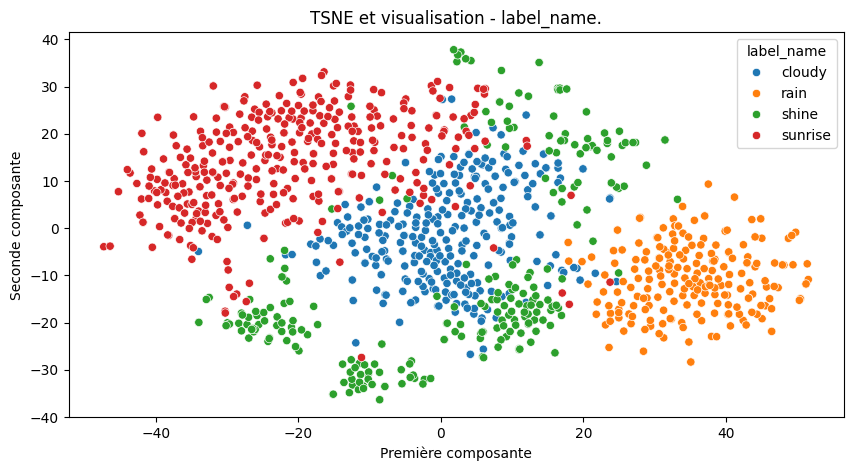

In [76]:
create_tsne_viz(tsne_df, "label_name")

Quelques interprétations :
- L'analyse graphique donne des indices visuels quand à la faisabilité de la séparation automatique des images selon leurs vraies classes -> se faire une idée sur la question. Cela permet d'estimer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images.
- Cette étape est plutôt rapide à réaliser, notamment parce qu'elle ne demande l'entraînement de task nets. Une conclusion négative sur la faisabilité peut permettre d'éviter de réaliser des traitements plus lourds. Cela permet également de discuter du caractère "naturel" du découpage en labels déjà effectué (il serait peut-être possible de découper ce même dataset en 4 groupes plus isolés, sur la base de l'extraction de features effectuées).
- On peut image que cette démarche en plusieurs étapes s'inscrive dans la démarche agile d'un projet data.

### Clustering (à partir de l'output du t-SNE)

Il s'agit ici de conforter simplement, par une mesure de l'ARI, l'analyse graphique précédente qui semble montrer la faisabilité relative d'une classification supervisée, avec des difficultés à prévoir pour segmenter les images "shine". Cette mesure de l'ARI nécessite de créer des clusters théoriques.
Pour réaliser une mesure de ce que nous voyons graphiquement, il faut partir des données en sorties du t-SNE. Pour toute autre application (classification ou segmentation réelle des images), il faudra repartir des features extraites par l'ensemble des étapes dédiées à cela, c'est-à-dire en sortie de l'ACP mais en amont du t-SNE.
Le score ARI est lié aux labels des données ; aussi rien ne garantit que la "meilleure" solution de feature engineering, si tant est qu'elle existe, sera celle qui génère le meilleur ARI.


Nous faisons ici le choix de mettre en oeuvre l'algorithme K-means. Mettre en oeuvre un tel modèle en fixant un nombre de clusters égal au nombre de classes anticipé (4).

In [89]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(tsne_X)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


Ajouter au dataframe des données extraites pour le t-SNE une colonne contenant le numéro du cluster affecté par K-means. En afficher un échantillon aléatoire de taille 10.

In [90]:
tsne_df["cluster_kmeans"] = kmeans.labels_

In [91]:
tsne_df.sample(10)

,tsne_one,tsne_two,label_name,cluster_kmeans
862,-4.169585,21.745012,sunrise,3
672,-21.922630,-8.517275,shine,0
212,15.363658,-7.989602,cloudy,1
1042,-29.659576,21.412846,sunrise,2
1031,-24.844881,-2.163594,sunrise,2
790,-29.872875,-8.858023,sunrise,2
580,20.987434,17.274124,shine,3
895,-38.956482,14.658885,sunrise,2
47,11.796440,11.169121,cloudy,3
500,40.304955,-18.261034,rain,1


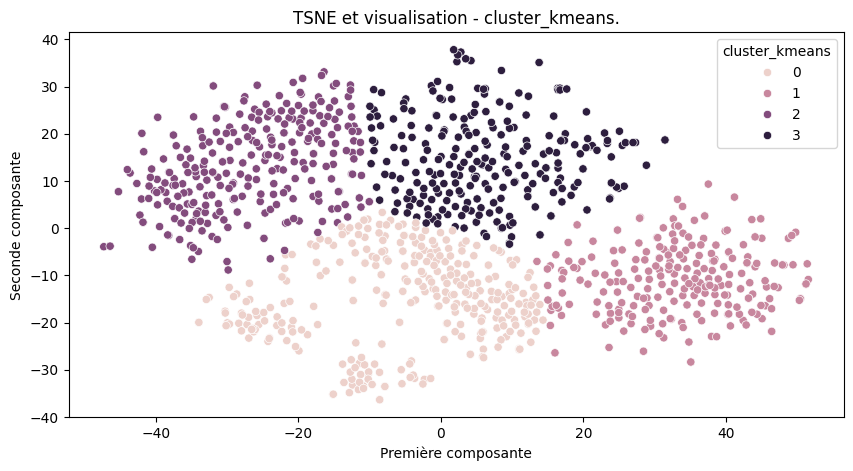

In [92]:
create_tsne_viz(tsne_df, "cluster_kmeans")

Effectuer à l'oeil une correspondance (bijective) entre les classes et les clusters (il est bien entendu possible d'automatiser la recherche d'une telle correspondance maximisant la métrique de similarité, mais ici, cela peut être réalisé visuellement).

In [93]:
cluster_class_map = {
    0: "shine",
    1: "rain",
    2: "sunrise",
    3: "cloudy",
}

Dénombrer le nombre d'images shine affectées au cluster cloudy.

In [109]:
mask = (tsne_df["label_name"] == "shine") & (tsne_df["cluster_kmeans"] == 3)
mask.sum()

np.int64(78)

Afficher une image shine considérée comme cloudy par le clustering. Essayer d'interpréter d'où peut venir la confusion (si possible).

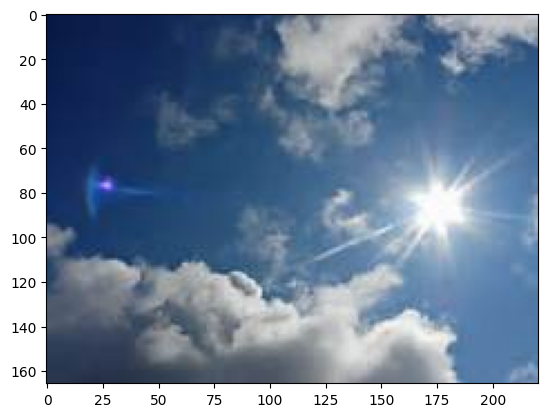

In [103]:
plt.imshow(
    plt.imread(
        img_df[mask].sample(1).reset_index().loc[0, "image_path"]
    )
)
plt.show()

Selon les images obtenues, la confusion peut venir de la présence de neige interprétée comme des nuages, la présence d'un ciel nuageux sans pluie avec du soleil, la présence d'un autre élément remarquable mais non indicateur de la classe (par exemple l'océan), la présence de features "non robustes" telles qu'une colorimétrie très particulière de l'image... Il est aussi possible de tomber sur une image pour laquelle la cause de la confusion n'est pas apparente à l'oeil humain !

Il est désormais temps d'avoir une analyse un peu plus globale des éléments cohérents et de la confusion.

### Analyse par classes

A l'aide de la fonction confusion_matrix du module metrics de scikit-learn, afficher la matrice de confusion brute de notre problème. Veiller à bien réaligner les classes et les clusters. Une fois la matrice brute obtenue, appeler la fonction de la cellule suivante pour améliorer le visuel.

In [110]:
from sklearn.metrics import confusion_matrix

cluster_labels = list(map(cluster_class_map.get, tsne_df["cluster_kmeans"]))

conf_mat = confusion_matrix(
    tsne_df["label_name"],
    cluster_labels,
    labels=LABELS_LIST,
)


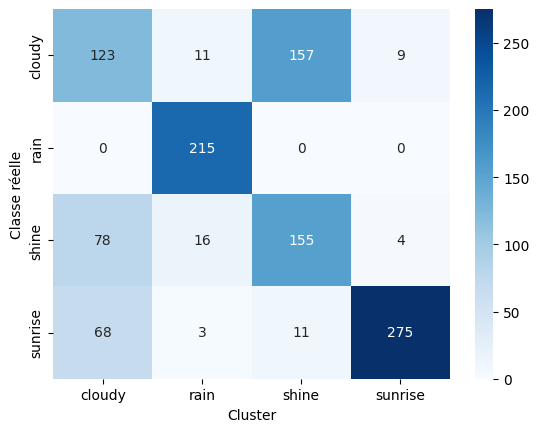

In [108]:
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Cluster")
plt.ylabel("Classe réelle")
plt.show()

Générer également un "rapport de classification" (toujours à partir du module metrics de scikit-learn).

In [ ]:
# Votre code ici

Pour terminer, calculer une mesure de similarité globale telle que le ARI score. Une fonction permettant de le calculer directement est (bien entendu) disponible dans scikit-learn. A votre avis, dans quel module ? Rechercher sur Internet pour savoir quelle est la fonction exacte à utiliser.

In [111]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(tsne_df["label_name"], cluster_labels)

0.47268314686075547

Cette fonction est-elle symétrique ? (Peut-on inverser valeurs réelles et prédites ?)

In [112]:
adjusted_rand_score(cluster_labels, tsne_df["label_name"])

0.47268314686075547

On se rend compte qu'on souhaitera probablement mettre en oeuvre une segmentation des images plus tard. Repérer la variable actuelle qu'on utilisera si on veut effectuer cette tâche sans refaire l'extraction de features (y compris la réduction de dimension), ainsi que celle qu'on utilisera si on souhaite tester plusieurs méthodes d'extraction de features. Les sauvegarder dans le dossier courant au format pickle.

## Classification

In [124]:
from tensorflow.keras.utils import to_categorical

In [117]:
def preprocess_image(image_path):
    img_array = img_to_array(load_img(image_path, target_size=(224, 224)))
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)[0]

In [122]:
X = np.stack(img_df["image_path"].apply(preprocess_image))

In [123]:
X

array([[[[  22.060997 ,    9.221001 ,    2.3199997],
         [  28.060997 ,   15.221001 ,    8.32     ],
         [  30.060997 ,   17.221    ,   10.32     ],
         ...,
         [  57.060997 ,   44.221    ,   37.32     ],
         [  51.060997 ,   38.221    ,   31.32     ],
         [  42.060997 ,   29.221    ,   22.32     ]],

        [[  23.060997 ,   10.221001 ,    3.3199997],
         [  28.060997 ,   15.221001 ,    8.32     ],
         [  30.060997 ,   17.221    ,   10.32     ],
         ...,
         [  51.060997 ,   38.221    ,   31.32     ],
         [  44.060997 ,   31.221    ,   24.32     ],
         [  35.060997 ,   22.221    ,   15.32     ]],

        [[  25.060997 ,   12.221001 ,    5.3199997],
         [  28.060997 ,   15.221001 ,    8.32     ],
         [  31.060997 ,   18.221    ,   11.32     ],
         ...,
         [  42.060997 ,   29.221    ,   22.32     ],
         [  33.060997 ,   20.221    ,   13.32     ],
         [  28.060997 ,   15.221001 ,    8.32     ]],

In [128]:
y = to_categorical(img_df["label"])

In [131]:
from sklearn.model_selection import train_test_split
X_macro_train, X_test, y_macro_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=1,
)

In [132]:
X_train, X_val, y_train, y_val = train_test_split(
    X_macro_train, y_macro_train,
    stratify=y_macro_train,
    test_size=0.2,
    random_state=1,
)

In [136]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

with tf.device("/cpu:0"):
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation="softmax")(x)
    
    model = Model(inputs=base_model.inputs, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [138]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [139]:
checkpoint = ModelCheckpoint(
    "./model_best.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
)

In [140]:
with tf.device("/cpu:0"):
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=64,
        callbacks=[checkpoint, es],
        verbose=1,
    )

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4956 - loss: 3.6477
Epoch 1: val_loss improved from None to 0.30251, saving model to ./model_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - accuracy: 0.6236 - loss: 2.0830 - val_accuracy: 0.9000 - val_loss: 0.3025
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8552 - loss: 0.4691
Epoch 2: val_loss improved from 0.30251 to 0.18661, saving model to ./model_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.8569 - loss: 0.4723 - val_accuracy: 0.9222 - val_loss: 0.1866
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8813 - loss: 0.3612
Epoch 3: val_loss improved from 0.18661 to 0.17328, saving model to ./model_best.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.8861 - loss: 0.3424 - val_accuracy: 0.9333 - val_loss: 0.1733
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8837 - loss: 0.2991
Epoch 4: val_loss did not improve from 0.17328
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.9069 - loss: 0.2514 - val_accuracy: 0.9111 - val_loss: 0.2123
Epoch 4: early stopping


In [143]:
loss, accuracy = model.evaluate(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9422 - loss: 0.1613


In [142]:
from plot_keras_history import show_history, plot_history

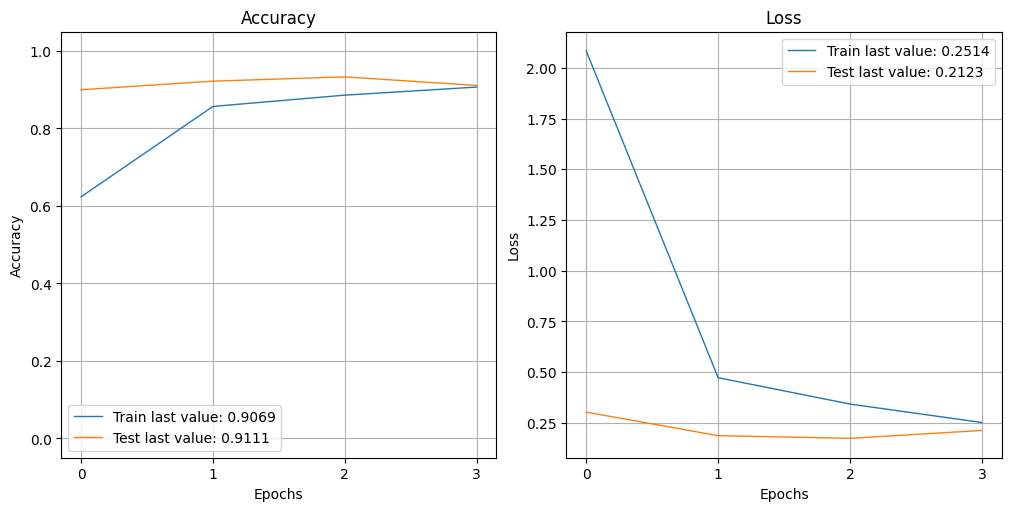

In [144]:
show_history(history)

In [148]:
y_val_num = np.argmax(y_val, axis=1)
y_pred_num = np.argmax(model.predict(X_val), axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


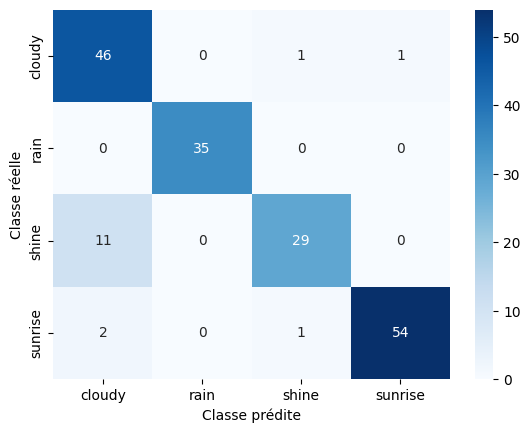

In [149]:
conf_mat = confusion_matrix(
    y_true=y_val_num,
    y_pred=y_pred_num,
)

sns.heatmap(
    conf_mat,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

In [152]:
from sklearn.metrics import classification_report
print(classification_report(y_val_num, y_pred_num))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86        48
           1       1.00      1.00      1.00        35
           2       0.94      0.72      0.82        40
           3       0.98      0.95      0.96        57

    accuracy                           0.91       180
   macro avg       0.92      0.91      0.91       180
weighted avg       0.92      0.91      0.91       180

